# Pre-processing Behavioral data
### Inspiration from Ronny Eichler pre-processing code


In [1]:
# Importation 
import numpy as np
import base64
import struct
from cobs import cobs
from collections import namedtuple
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from tqdm.notebook import tqdm
import scipy.signal
from scipy.io import savemat
import rawpy
import imageio
import os

#### Decoding 

In [3]:
Path_non_decoded_files= '/home/melisamc/Documentos/acc_2p_analysis/data/log_files/'
Path_decoded ='/home/melisamc/Documentos/acc_2p_analysis/logfiles_decoded/'

for filename in os.listdir(Path_non_decoded_files):
    if filename.endswith(".b64"):
        bp=os.path.join(Path_non_decoded_files, filename)
      # Format package
        DataPacketDesc = {'type': 'B',
                          'size': 'B',
                          'crc16': 'H',
                          'packetID': 'I',
                          'us_start': 'I',
                          'us_end': 'I',
                          'analog': '8H',
                          'states': '8l',
                          'digitalIn': 'H',
                          'digitalOut': 'B',
                          'padding': 'x'}


        DataPacket = namedtuple('DataPacket', DataPacketDesc.keys())
        DataPacketStruct = '<' + ''.join(DataPacketDesc.values())
        DataPacketSize = struct.calcsize(DataPacketStruct)

        # package with non-digital data
        dtype_no_digital = [
            ('type', np.uint8),
            ('size', np.uint8),
            ('crc16', np.uint16),
            ('packetID', np.uint32),
            ('us_start', np.uint32),
            ('us_end', np.uint32),
            ('analog', np.uint16, (8, )),
            ('states', np.uint32, (8, ))]

        # DigitalIn and DigitalOut
        dtype_w_digital = dtype_no_digital + [('digital_in', np.uint16, (16, )), ('digital_out', np.uint8, (8, ))]

        # Creating arrat with all the data (differenciation digital/non digital)
        np_DataPacketType_noDigital = np.dtype(dtype_no_digital)
        np_DataPacketType_withDigital = np.dtype(dtype_w_digital)
        # Unpack the data as done on the teensy commander code
        
        # function to count the packet number
        def count_lines(fp):
            def _make_gen(reader):
                b = reader(2**16)
                while b:
                    yield b
                    b = reader(2**16)
            with open(fp, 'rb') as f:
                count = sum(buf.count(b'\n') for buf in _make_gen(f.raw.read))
            return count
        
        %time num_lines = count_lines(bp)
        log_duration = num_lines/1000/60
        print(bp)
        print(f'{num_lines} packets, ~{log_duration:0.2f} minutes')

        def unpack_data_packet(dp):
            s = struct.unpack(DataPacketStruct, dp)
            up = DataPacket(type=s[0], size=s[1], crc16=s[2], packetID=s[3], us_start=s[4], us_end=s[5],
                                analog=s[6:14], states=s[14:22], digitalIn=s[22], digitalOut=s[23], padding=None)

            return up
        
        # Decode and create new dataset
        data = np.zeros(num_lines, dtype=np_DataPacketType_withDigital)
        non_digital_names = list(np_DataPacketType_noDigital.names)

        with open(bp, 'rb') as bf:
            for nline, line in enumerate(tqdm(bf, total=num_lines)):
                bl = cobs.decode(base64.b64decode(line[:-1])[:-1])
                dp = unpack_data_packet(bl)

                data[non_digital_names][nline] = np.frombuffer(bl[:-4], dtype=np_DataPacketType_noDigital)
                digital_arr = np.frombuffer(bl[-4:], dtype=np.uint8)
                data[nline]['digital_in'] = np.hstack([np.unpackbits(digital_arr[1]), np.unpackbits(digital_arr[0])])
                data[nline]['digital_out'] = np.unpackbits(np.array(digital_arr[2], dtype=np.uint8))
        #Check for packetID jumps
        jumps = np.unique(np.diff(data['packetID']))
        
        
        #assert(len(jumps) and jumps[0] == 1)
        decoded = {"analog":data['analog'], "digitalIn":data['digital_in'], "digitalOut":data['digital_out'], "startTS":data['us_start'], "transmitTS":data['us_end'], "longVar":data['states'], "packetNums":data['packetID']}
        name=os.path.splitext(filename)[0]
        print(name)
        path=os.path.join(Path_decoded, name +'_decoded'+'.mat')
        savemat(path, decoded)

CPU times: user 178 ms, sys: 50.7 ms, total: 229 ms
Wall time: 233 ms
/home/melisamc/Documentos/acc_2p_analysis/data/log_files/20220513-165536_677.b64
2085888 packets, ~34.76 minutes


  0%|          | 0/2085888 [00:00<?, ?it/s]

20220513-165536_677


In [4]:
x = data['states']

In [16]:
x.shape

(2085888, 8)

(250000.0, 500000.0)

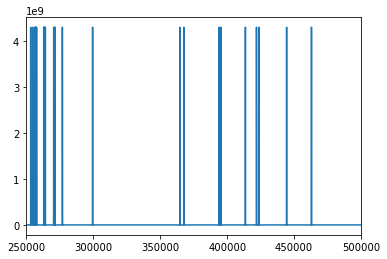

In [39]:
import matplotlib.pyplot as plt
import scipy as sp

figure, axes = plt.subplots()
axes.plot(np.diff(x[:,1]))
#axes.set_ylim([0,10])
axes.set_xlim([250000,500000])

(250000.0, 500000.0)

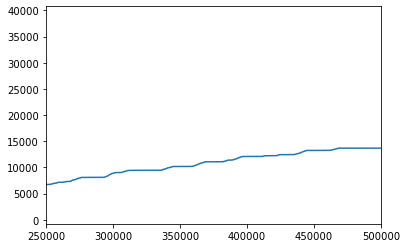

In [38]:
figure, axes = plt.subplots()
axes.plot(x[:,1])
axes.set_xlim([250000,500000])